<a href="https://colab.research.google.com/github/DrSnek/PocketDoctor/blob/main/Kidney.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Data Processing



In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

import itertools
from sklearn.impute import SimpleImputer

from sklearn import model_selection
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn import svm

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

!pip install tflearn

from keras.models import Sequential, Model
from keras.layers import Conv2D, Dropout, MaxPooling2D, Input
from keras.layers import BatchNormalization, Activation, Flatten, Dense
from tensorflow.keras import initializers

!pip install anvil-uplink

import anvil.server
anvil.server.connect("VFITZUSM3GHE46KQMIY7X3MH-JVTABAU63SWWZ5GO")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


In [ ]:
url = "https://drive.google.com/file/d/1cmofohD5--zpPOLFanQzKMk2XlFGKqyC/view?usp=sharing"
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
df = pd.read_csv(url)
df.head()

,id,age,bp,sg,al,su,rbc,pc,pcc,ba,...,pcv,wc,rc,htn,dm,cad,appet,pe,ane,classification
0,0,48,80,1.020,1,0,NaN,normal,notpresent,notpresent,...,44.0,7800.0,5.2,1,1,0,1,0,0,1
1,1,7,50,1.020,4,0,NaN,normal,notpresent,notpresent,...,38.0,6000.0,NaN,0,0,0,1,0,0,1
2,2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,...,31.0,7500.0,NaN,0,1,0,0,0,1,1
3,3,48,70,1.005,4,0,normal,abnormal,present,notpresent,...,32.0,6700.0,3.9,1,0,0,0,1,1,1
4,4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,...,35.0,7300.0,4.6,0,0,0,1,0,0,1


### Functions:

In [ ]:
def print_accuracy(y_test, y_pred):
  print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(y_test, y_pred)))
  print("%-12s %f" % ('Precision:', metrics.precision_score(y_test, y_pred,labels=None, pos_label=1, average='binary', sample_weight=None)))
  print("%-12s %f" % ('Recall:', metrics.recall_score(y_test, y_pred,labels=None, pos_label=1, average='binary', sample_weight=None)))
  print("%-12s %f" % ('F1 Score:', metrics.f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)))
  print()

def draw_confusion_matrix(y_test, y_pred, classes):
  plt.cla()
  plt.clf()
  matrix = confusion_matrix(y_test, y_pred)
  plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
  plt.title("Confusion Matrix")
  plt.colorbar()
  num_classes = len(classes)
  plt.xticks(np.arange(num_classes), classes, rotation=90)
  plt.yticks(np.arange(num_classes), classes)
  fmt = 'd'
  thresh = matrix.max() / 2.
  for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
    plt.text(j, i, format(matrix[i, j], fmt), horizontalalignment="center", color="white" if matrix[i, j] > thresh else "black")
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.tight_layout()
  plt.show()
  print()

In [ ]:
def draw_roc_curve(y_test, y_score, title, c="blue", line_width=1):
  fpr_log_reg, tpr_log_reg, thresholds = metrics.roc_curve(y_test, y_score)
  plt.figure(2)
  aucroc = metrics.auc(fpr_log_reg, tpr_log_reg)
  plt.plot(fpr_log_reg, tpr_log_reg, color=c, lw=line_width, label = 'AUC = %0.3f' % aucroc)
  plt.title(title)
  plt.xlabel('False Positive Rates')
  plt.ylabel('True Positive Rates')
  plt.legend(loc = 'lower right')
  plt.show()
  print()

def draw_roc_curve_individual(y_test, y_score, label, line_width=1):
  fpr_log_reg, tpr_log_reg, thresholds = metrics.roc_curve(y_test, y_score)
  # plt.figure(2)
  aucroc = metrics.auc(fpr_log_reg, tpr_log_reg)
  plt.plot(fpr_log_reg, tpr_log_reg, lw=line_width, label = label + ', AUC = %0.3f' % aucroc)
  # plt.title(title)
  plt.xlabel('False Positive Rates')
  plt.ylabel('True Positive Rates')


## Data Cleaning:

In [ ]:
data = df
print(data)
for i in range(data.shape[0]):
    if data.iloc[i,25]=='ckd\t':
        data.iloc[i,25]='ckd'
    if data.iloc[i,20] in [' yes','\tyes']:
        data.iloc[i,20]='yes'
    if data.iloc[i,20]=='\tno':
        data.iloc[i,20]='no'
    if data.iloc[i,21]=='\tno':
        data.iloc[i,21]='no'
    if data.iloc[i,16]=='\t?':
        data.iloc[i,16]=np.nan
    if data.iloc[i,16]=='\t43':
        data.iloc[i,16]='43'
    if data.iloc[i,17]=='\t?':
        data.iloc[i,17]=np.nan
    if data.iloc[i,17]=='\t6200':
        data.iloc[i,17]= '6200'
    if data.iloc[i,17]=='\t8400':
        data.iloc[i,17]= '6200'
    if data.iloc[i,18]=='\t?':
        data.iloc[i,18]=np.nan
    if data.iloc[i,25]=='ckd':
        data.iloc[i,25]='yes'
    if data.iloc[i,25]=='notckd':
        data.iloc[i,25]='no'

      id  age  bp     sg  al  su     rbc        pc         pcc          ba  \
0      0   48  80  1.020   1   0     NaN    normal  notpresent  notpresent   
1      1    7  50  1.020   4   0     NaN    normal  notpresent  notpresent   
2      2   62  80  1.010   2   3  normal    normal  notpresent  notpresent   
3      3   48  70  1.005   4   0  normal  abnormal     present  notpresent   
4      4   51  80  1.010   2   0  normal    normal  notpresent  notpresent   
..   ...  ...  ..    ...  ..  ..     ...       ...         ...         ...   
278  395   55  80  1.020   0   0  normal    normal  notpresent  notpresent   
279  396   42  70  1.025   0   0  normal    normal  notpresent  notpresent   
280  397   12  80  1.020   0   0  normal    normal  notpresent  notpresent   
281  398   17  60  1.025   0   0  normal    normal  notpresent  notpresent   
282  399   58  80  1.025   0   0  normal    normal  notpresent  notpresent   

     ...   pcv      wc   rc  htn  dm  cad  appet  pe  ane  clas

In [ ]:
data = data.drop(['id'], axis = 1)
df2 = data.drop(['sg'], axis = 1)
df3 = df2.drop(['al'], axis = 1)
df4 = df3.drop(['pc'], axis = 1)
df5 = df4.drop(['pcc'], axis = 1)
df6 = df5.drop(['sod'], axis = 1)
df7 = df6.drop(['pot'], axis = 1)
df8 = df7.drop(['rbc'], axis = 1)
df9 = df8.drop(['ba'], axis = 1)
df10 = df9.drop(['bgr'], axis = 1)
df11 = df10.drop(['sc'], axis = 1)
df12 = df11.drop(['pcv'], axis = 1)
df13 = df12.drop(['htn'], axis = 1)
df14 = df13.drop(['dm'], axis = 1)
data = df14.drop(['pe'], axis = 1)

In [ ]:
print(data['wc'].unique())
print(data['rc'].unique())

[ 7800.  6000.  7500.  6700.  7300.    nan  9600. 12100.  4500. 12200.
 11000.  3800. 11400.  5300.  9200.  6900.  8400. 10300.  9800.  9100.
  7900.  6400.  8600. 18900. 21600.  4300.  8500. 11300.  7200.  7700.
  8300. 14600.  6200.  7100. 11800.  9400.  5800. 12500.  5600.  7000.
 11900. 10400. 10700. 12700.  6800. 13600. 10200.  9000. 14900.  5500.
  8200. 15200.  5000. 16300. 12400.  6500. 10500.  4200.  4700. 10900.
  8100.  2200. 12800. 11200. 19100. 16700.  2600. 26400.  8800.  7400.
  4900.  8000. 12000. 15700.  4100.  5700. 11500.  5400.  9500.  6300.
  9900.  5200.  5900.  9300.  9700.  5100.  6600.]
[5.2 nan 3.9 4.6 4.4 4.  3.7 3.8 3.4 2.6 2.8 4.3 3.2 4.1 4.9 4.2 4.5 3.1
 4.7 3.5 6.  5.  2.1 5.6 3.6 2.9 2.7 8.  3.3 3.  4.8 6.1 2.5 6.2 6.3 5.1
 5.8 5.5 5.3 5.4 6.4 5.9 5.7 6.5]


## Data Analysis:

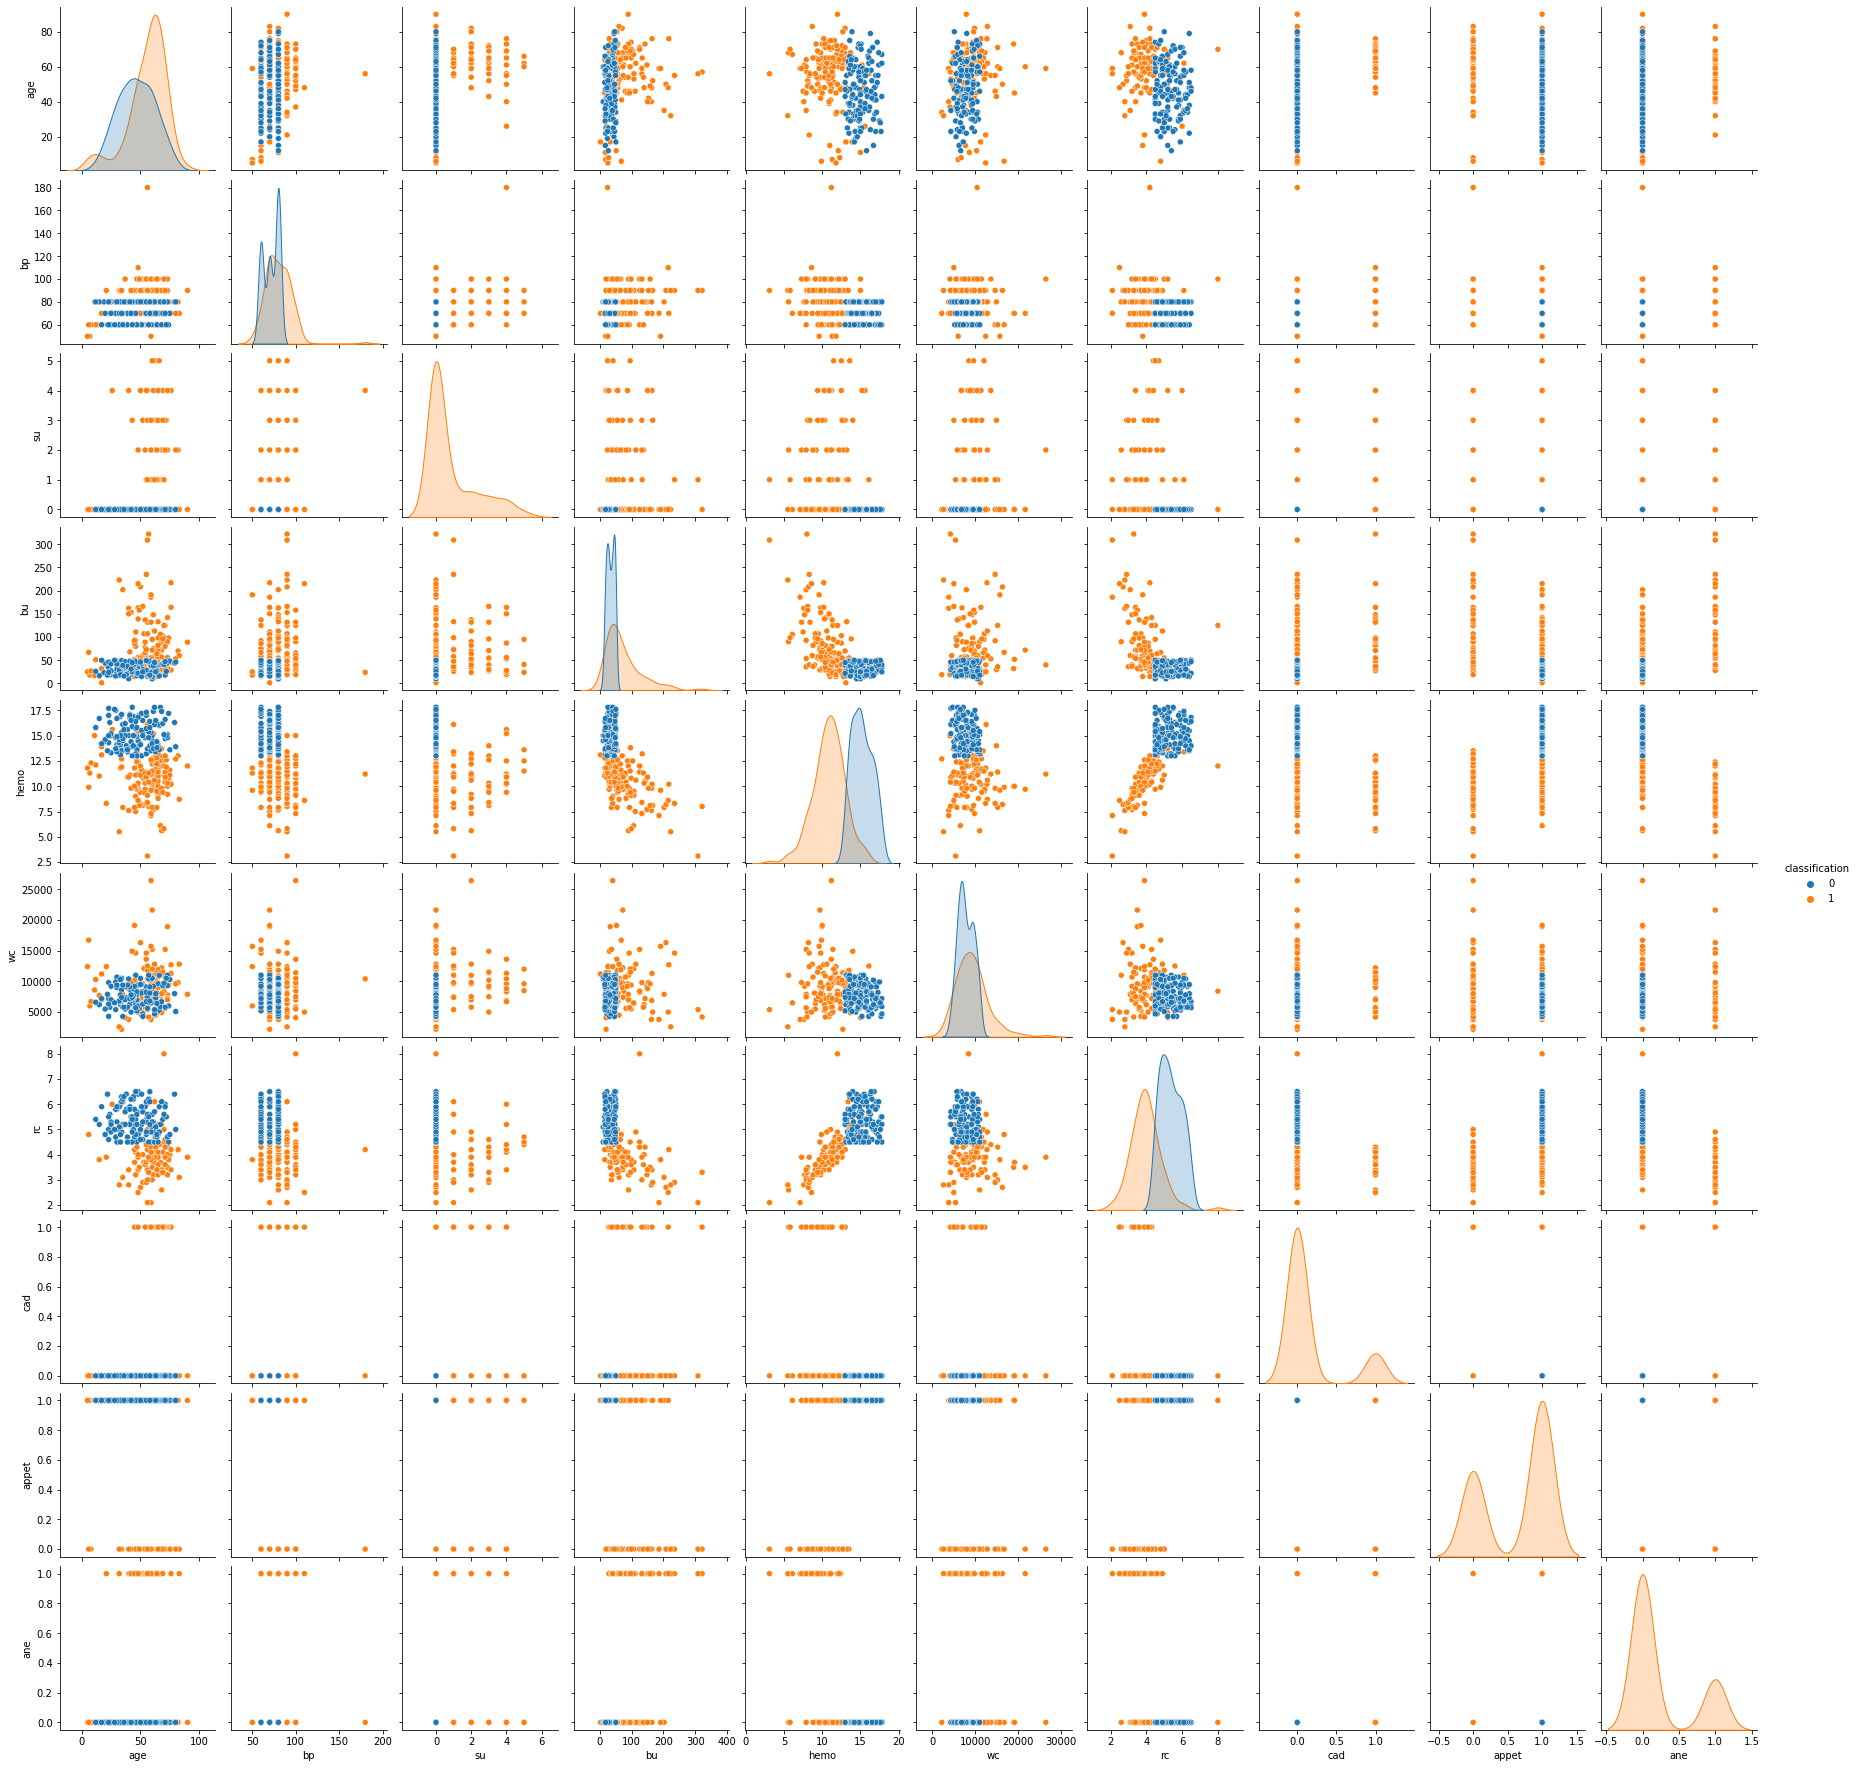

In [ ]:
sns.pairplot(data = data, hue = 'classification')

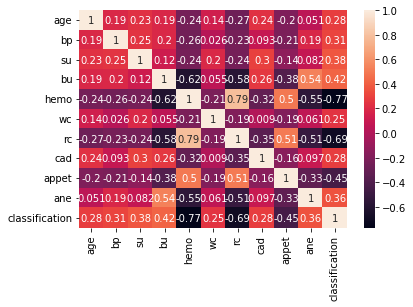

In [ ]:
sns.heatmap(data.corr(), annot = True)

K = 2

In [ ]:
print(data)
data = data.drop(['rc'], axis = 1)
data = data.drop(['wc'], axis = 1)
data = data.drop(['su'], axis = 1)

     age  bp  su    bu  hemo      wc   rc  cad  appet  ane  classification
0     48  80   0  36.0  15.4  7800.0  5.2    0      1    0               1
1      7  50   0  18.0  11.3  6000.0  NaN    0      1    0               1
2     62  80   3  53.0   9.6  7500.0  NaN    0      0    1               1
3     48  70   0  56.0  11.2  6700.0  3.9    0      0    1               1
4     51  80   0  26.0  11.6  7300.0  4.6    0      1    0               1
..   ...  ..  ..   ...   ...     ...  ...  ...    ...  ...             ...
278   55  80   0  49.0  15.7  6700.0  4.9    0      1    0               0
279   42  70   0  31.0  16.5  7800.0  6.2    0      1    0               0
280   12  80   0  26.0  15.8  6600.0  5.4    0      1    0               0
281   17  60   0  50.0  14.2  7200.0  5.9    0      1    0               0
282   58  80   0  18.0  15.8  6800.0  6.1    0      1    0               0

[283 rows x 11 columns]


## Model:

In [ ]:
user_backup = data

X = data.drop("classification", axis = 1)
Y = data["classification"].copy()

print("X shape before processing is", X.shape)
df_numerical = X.drop(["cad", "appet", "ane"], axis = 1)

numerical_pipeline = Pipeline([
                               ("std_scaler", StandardScaler())
                               ])

numerical_features = list(df_numerical)
categorical_features = ["cad", "appet", "ane"]

full_pipeline = ColumnTransformer([
                ("numerical", numerical_pipeline, numerical_features), 
                ("categorical", OneHotEncoder(), categorical_features)
                ])
X_prepared = full_pipeline.fit_transform(X)

print("X shape after processing is", X_prepared.shape)

X shape before processing is (283, 7)
X shape after processing is (283, 10)


In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size = 0.3, random_state = 42)

In [ ]:
print(data.isnull().sum())

age               0
bp                0
bu                0
hemo              0
cad               0
appet             0
ane               0
classification    0
dtype: int64


In [ ]:
x_test

,age,bp,bu,hemo,cad,appet,ane
9,50,60,55.0,9.4,0,1,1
246,29,80,16.0,13.7,0,1,0
139,60,90,95.0,11.5,0,1,0
207,55,80,28.0,17.3,0,1,0
75,12,60,51.0,12.1,0,1,0
...,...,...,...,...,...,...,...
18,48,80,163.0,9.8,0,1,1
117,61,80,23.0,11.3,0,1,0
274,36,80,16.0,15.6,0,1,0
84,75,70,49.0,11.1,0,0,0


Accuracy:    0.823529
Precision:   0.880952
Recall:      0.787234
F1 Score:    0.831461



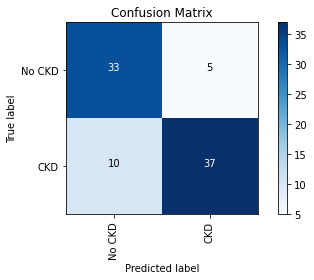

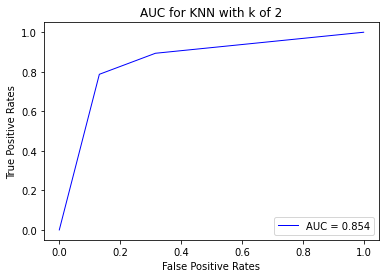

In [ ]:
knn = KNeighborsClassifier(n_neighbors = 2)
knn.fit(x_train, y_train)
y_pred = knn.predict(x_test)
y_score = knn.predict_proba(x_test)[:, 1]

print_accuracy(y_test, y_pred)
draw_confusion_matrix(y_test, y_pred, ["No CKD", "CKD"])
draw_roc_curve(y_test, y_score, title = "AUC for KNN with k of 2")

In [ ]:
@anvil.server.callable
def Kidknees(ageINP, bloodpressureINP, sugarINP, bloodureaINP, haemoglobinINP, CADINP, appetiteINP, anemiaINP):
  #user_input = [["age", "blood pressure", "sugar", "blood urea", "haemoglobin", "CAD", "appetite", "anemia", "classification"]]
  classification_placeholder = 1
  user_input = [[ageINP, bloodpressureINP, sugarINP, bloodureaINP, haemoglobinINP, CADINP, appetiteINP, anemiaINP, classification_placeholder]]

  user_df = pd.DataFrame(user_input, columns=["age", "bp", "su", "bu", "hemo", "cad", "appet", "ane", "classification"])
  df = user_backup.append(user_df, ignore_index=True)

  X = df.drop("classification", axis = 1)
  Y = df["classification"].copy()

  y_temp = knn.predict(X)
  return(y_temp[0])
anvil.server.wait_forever()